# Quantization of Image Classification Models

This tutorial demonstrates how to apply `INT8` quantization to Image Classification model using [Post-training Optimization Tool API](../../compression/api/README.md). It also assumes that OpenVINO™ is already installed and it uses the Mobilenet V2 model, trained on Cifar10 dataset. The code is designed to be extendable to custom models and datasets. 

This tutorial consists of the following steps:
- Prepare the model for quantization.
- Define a data loading and an accuracy validation functionality.
- Run optimization pipeline.
- Compare accuracy of the original and quantized models.
- Compare performance of the original and quantized models.
- Compare results on one picture.



In [1]:
import os
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
from openvino.tools.pot.api import DataLoader, Metric
from openvino.tools.pot.engines.ie_engine import IEEngine
from openvino.tools.pot.graph import load_model, save_model
from openvino.tools.pot.graph.model_utils import compress_model_weights
from openvino.tools.pot.pipeline.initializer import create_pipeline
from openvino.runtime import Core
from torchvision import transforms
from torchvision.datasets import CIFAR10

/home/ea/work/notebooks_env/lib/python3.8/site-packages/openvino/offline_transformations/__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future.
  warnings.warn(


[ DEBUG ] Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
[ DEBUG ] Creating converter from 7 to 5
[ DEBUG ] Creating converter from 5 to 7
[ DEBUG ] Creating converter from 7 to 5
[ DEBUG ] Creating converter from 5 to 7


In [2]:
# Set the data and model directories
DATA_DIR = '../data/datasets/cifar10'
MODEL_DIR = 'model'
model_repo = 'pytorch-cifar-models'

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

## Prepare the Model
Model preparation stage has the following steps:
- Download a PyTorch model from Torchvision repository
- Convert it to ONNX format
- Run Model Optimizer to convert ONNX to OpenVINO Intermediate Representation (OpenVINO IR)



In [3]:
if not Path(model_repo).exists():
    !git clone https://github.com/chenyaofo/pytorch-cifar-models.git

sys.path.append(model_repo)

In [4]:
from pytorch_cifar_models import cifar10_mobilenetv2_x1_0

model = cifar10_mobilenetv2_x1_0(pretrained=True)

In [5]:
import torch

model.eval()

dummy_input = torch.randn(1, 3, 32, 32)

onnx_model_path = Path(MODEL_DIR) / 'mobilenet_v2.onnx'
ir_model_xml = onnx_model_path.with_suffix('.xml')
ir_model_bin = onnx_model_path.with_suffix('.bin')

torch.onnx.export(model, dummy_input, onnx_model_path)

# Run Model Optimizer to convert ONNX to OpenVINO IR.
!mo --compress_to_fp16 -m $onnx_model_path  --output_dir $MODEL_DIR

[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /home/ea/work/openvino_notebooks/notebooks/113-image-classification-quantization/model/mobilenet_v2.xml
[ SUCCESS ] BIN file: /home/ea/work/openvino_notebooks/notebooks/113-image-classification-quantization/model/mobilenet_v2.bin


## Define Data Loader
In this step, the `DataLoader` interface from POT API is implemented.

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
dataset = CIFAR10(root=DATA_DIR, train=False, transform=transform, download=True)

Files already downloaded and verified


In [7]:
# Create a DataLoader from a CIFAR10 dataset.
class CifarDataLoader(DataLoader):

    def __init__(self, config):
        """
        Initialize config and dataset.
        :param config: created config with DATA_DIR path.
        """
        super().__init__(config)
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Return one sample of index, label and picture.
        :param index: index of the taken sample.
        """
        image, label = self.dataset[index]
        return (index, label), image.numpy()

    def load_data(self, dataset):
        """
        Load dataset in needed format. 
        :param dataset:  downloaded dataset.
        """
        pictures, labels, indexes = [], [], []
        
        for idx, sample in enumerate(dataset):
            pictures.append(sample[0])
            labels.append(sample[1])
            indexes.append(idx)

        return indexes, pictures, labels

## Define Accuracy Metric Calculation
In this step, the `Metric` interface for accuracy Top-1 metric is implemented. It is used for validating accuracy of quantized model.

In [8]:
# Custom implementation of classification accuracy metric.

class Accuracy(Metric):

    # Required methods
    def __init__(self, top_k=1):
        super().__init__()
        self._top_k = top_k
        self._name = 'accuracy@top{}'.format(self._top_k)
        self._matches = []

    @property
    def value(self):
        """ Returns accuracy metric value for the last model output. """
        return {self._name: self._matches[-1]}

    @property
    def avg_value(self):
        """ Returns accuracy metric value for all model outputs. """
        return {self._name: np.ravel(self._matches).mean()}

    def update(self, output, target):
        """ Updates prediction matches.
        :param output: model output
        :param target: annotations
        """
        if len(output) > 1:
            raise Exception('The accuracy metric cannot be calculated '
                            'for a model with multiple outputs')
        if isinstance(target, dict):
            target = list(target.values())
        predictions = np.argsort(output[0], axis=1)[:, -self._top_k:]
        match = [float(t in predictions[i]) for i, t in enumerate(target)]

        self._matches.append(match)

    def reset(self):
        """ Resets collected matches """
        self._matches = []

    def get_attributes(self):
        """
        Returns a dictionary of metric attributes {metric_name: {attribute_name: value}}.
        Required attributes: 'direction': 'higher-better' or 'higher-worse'
                             'type': metric type
        """
        return {self._name: {'direction': 'higher-better',
                             'type': 'accuracy'}}

## Run Quantization Pipeline and compare the accuracy of the original and quantized models
In this step, define a configuration for the quantization pipeline and run it.

> **NOTE**: Use built-in `IEEngine` implementation of the `Engine` interface from the POT API for model inference. `IEEngine` is built on top of OpenVINO Python API for inference and provides basic functionality for inference of simple models. If you have a more complicated inference flow for your model/models, you should create your own implementation of `Engine` interface, for example, by inheriting from `IEEngine` and extending it.

In [9]:
model_config = {
    'model_name': 'mobilenet_v2',
    'model': ir_model_xml,
    'weights': ir_model_bin
}
engine_config = {'device': 'CPU'}
dataset_config = {
    'data_source': DATA_DIR
}
algorithms = [
    {
        'name': 'DefaultQuantization',
        'params': {
            'target_device': 'CPU',
            'preset': 'performance',
            'stat_subset_size': 300
        }
    }
]

# Steps 1-7: Model optimization
# Step 1: Load the model.
model = load_model(model_config)

# Step 2: Initialize the data loader.
data_loader = CifarDataLoader(dataset_config)

# Step 3 (Optional. Required for AccuracyAwareQuantization): Initialize the metric.
metric = Accuracy(top_k=1)

# Step 4: Initialize the engine for metric calculation and statistics collection.
engine = IEEngine(engine_config, data_loader, metric)

# Step 5: Create a pipeline of compression algorithms.
pipeline = create_pipeline(algorithms, engine)

# Step 6: Execute the pipeline.
compressed_model = pipeline.run(model)

# Step 7 (Optional): Compress model weights quantized precision
#                    in order to reduce the size of final .bin file.
compress_model_weights(compressed_model)

# Step 8: Save the compressed model to the desired path.
compressed_model_paths = save_model(model=compressed_model, save_path=MODEL_DIR, model_name="quantized_mobilenet_v2"
)
compressed_model_xml = compressed_model_paths[0]["model"]
compressed_model_bin = Path(compressed_model_paths[0]["model"]).with_suffix(".bin")

# Step 9: Compare accuracy of the original and quantized models.
metric_results = pipeline.evaluate(model)
if metric_results:
    for name, value in metric_results.items():
        print(f"Accuracy of the original model: {name}: {value}")

metric_results = pipeline.evaluate(compressed_model)
if metric_results:
    for name, value in metric_results.items():
        print(f"Accuracy of the optimized model: {name}: {value}")

Accuracy of the original model: accuracy@top1: 0.9353
Accuracy of the optimized model: accuracy@top1: 0.9353


## Compare Performance of the Original and Quantized Models

Finally, measure the inference performance of the `FP32` and `INT8` models, using [Benchmark Tool](https://docs.openvino.ai/2023.0/openvino_inference_engine_tools_benchmark_tool_README.html) - an inference performance measurement tool in OpenVINO.

> **NOTE**: For more accurate performance, it is recommended to run benchmark_app in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change CPU to GPU to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.


In [10]:
# Inference FP16 model (OpenVINO IR)
!benchmark_app -m $ir_model_xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-9771-d7f47aa1228
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-9771-d7f47aa1228
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 24.41 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     input.1 (node: input.1) : f32 / [...] / [1,3,32,32]
[ INFO ] Model outputs:
[ INFO ]     536 (node: 536) : f32 / [...] / [1,10]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:
[ INFO ]     i

In [11]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m $compressed_model_xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-9771-d7f47aa1228
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-9771-d7f47aa1228
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 23.71 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     input.1 (node: input.1) : f32 / [...] / [1,3,32,32]
[ INFO ] Model outputs:
[ INFO ]     536 (node: 536) : f32 / [...] / [1,10]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:
[ INFO ]     i

## Compare results on four pictures.

In [12]:
ie = Core()

# Read and load a float model.
float_model = ie.read_model(
    model=ir_model_xml, weights=ir_model_bin
)
float_compiled_model = ie.compile_model(model=float_model, device_name="CPU")

# Read and load a quantized model.
quantized_model = ie.read_model(
    model=compressed_model_xml, weights=compressed_model_bin
)
quantized_compiled_model = ie.compile_model(model=quantized_model, device_name="CPU")

In [13]:
# Define all possible labels from the CIFAR10 dataset.
labels_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
all_pictures = []
all_labels = []

# Get all pictures and their labels.
for i, batch in enumerate(data_loader):
    all_pictures.append(batch[1])
    all_labels.append(batch[0][1])

In [14]:
def plot_pictures(indexes: list, all_pictures=all_pictures, all_labels=all_labels):
    """Plot 4 pictures.
    :param indexes: a list of indexes of pictures to be displayed.
    :param all_batches: batches with pictures.
    """
    images, labels = [], []
    num_pics = len(indexes)
    assert num_pics == 4, f'No enough indexes for pictures to be displayed, got {num_pics}'
    for idx in indexes:
        assert idx < 10000, 'Cannot get such index, there are only 10000'
        pic = np.rollaxis(all_pictures[idx].squeeze(), 0, 3)
        images.append(pic)

        labels.append(labels_names[all_labels[idx]])

    f, axarr = plt.subplots(1, 4)
    axarr[0].imshow(images[0])
    axarr[0].set_title(labels[0])

    axarr[1].imshow(images[1])
    axarr[1].set_title(labels[1])

    axarr[2].imshow(images[2])
    axarr[2].set_title(labels[2])

    axarr[3].imshow(images[3])
    axarr[3].set_title(labels[3])

In [26]:
from openvino.runtime import Tensor

def infer_on_pictures(model, indexes: list, all_pictures=all_pictures):
    """ Inference model on a few pictures.
    :param net: model on which do inference
    :param indexes: list of indexes 
    """
    output_key = model.output(0)
    predicted_labels = []
    for idx in indexes:
        assert idx < 10000, 'Cannot get such index, there are only 10000'
        result = model(Tensor(all_pictures[idx][None,]))[output_key]
        result = labels_names[np.argmax(result[0])]
        predicted_labels.append(result)
    return predicted_labels

Labels for picture from float model : ['frog', 'dog', 'ship', 'horse'].
Labels for picture from quantized model : ['frog', 'dog', 'ship', 'horse'].


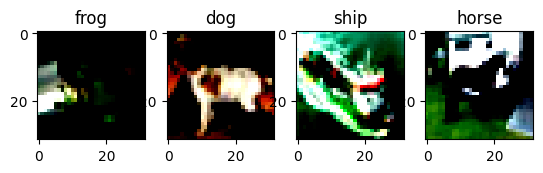

In [27]:
indexes_to_infer = [7, 12, 15, 20]  # To plot, specify 4 indexes.

plot_pictures(indexes_to_infer)

results_float = infer_on_pictures(float_compiled_model, indexes_to_infer)
results_quanized = infer_on_pictures(quantized_compiled_model, indexes_to_infer)

print(f"Labels for picture from float model : {results_float}.")
print(f"Labels for picture from quantized model : {results_quanized}.")